<h1 style="color:blue"> Introduction Relational Databases: Data Models and SQL</h2>


### Much of scientific data comes in the form of tabular data formats: excel, CSV, TSV. 
#### Once the data gets large or more complex, e.g. distributed over multiple files or formats, handling the data becomes cumbersome. Then "relational databases" can be of great help. This class deals with this technology.

### Much statistical data analysis deals with
#### Creating uniform samples 
#### Data filtering
#### Assembling relevant subsets
#### Estimating completeness 
#### Censoring bad data
#### Counting and building histograms
#### Generating Monte-Carlo subsets
#### Likelihood calculations
#### Hypothesis testing

### Traditionally these are performed on files
### Most of these tasks are much better done inside a database

<hr/>

## Motivations for using a relational database
#### encapsulation of data in terms of logical structure, no need to know about internals of data storage
#### standard query language for finding information: SQL
#### advanced query optimizers to minimize I/O (indexes, clustering)
#### transparent internal parallelization
#### authenticated remote access for multiple users at same time
<br/>

#### forces one to think carefully about data structure
#### speeds up path from (science) question to answer
#### facilitates communication (query code is cleaner)



<hr/>

## Relational database consists of Tables
<img src="img/table.png" width=700/>

## Data model for university courses

### **Course**: code, name, credits, description, ...
### **Teacher**: name, email, office.
### **Students**: name, email, ...

## `Courses` table
<img src="img/course.png"/>

### Table DDL (data definition language):
```sql
create table courses (
    number varchar(6) not null,
    name varchar(32) not null,
    description varchar(1024),
    credits int 
);
```

## Sequential Query Language (SQL, "sequel")

### `SELECT ... FROM ... WHERE ...`

## CasJobs

In <a href="http://scitest02.pha.jhu.edu/CasJobs/SubmitJob.aspx" target="_blank">CasJobs</a>, using IPDSDB as context, try:
```sql
SELECT number, name, description, credits
  FROM courses
```
<br/>
<img src="img/query_course.png"/><br/><br/>


## now from this notebook:

In [1]:
import SciServer.CasJobs as cj
import pandas
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)

In [2]:
sql="""
SELECT number, name, description, credits
  FROM courses
"""
df=cj.executeQuery(sql,"IPDSDB")
df

,number,name,description,credits
0,SDV100,College Success Skills,,1
1,ITD110,Web Page Design I,An introduction to web page design,3
2,ITP100,Software Design,General software design principles,3
3,ITD132,Structured Query Language,,3
4,ITP140,Client Side Scripting,,4
5,ITP225,Web Scripting Languages,,4


Try:
```sql
SELECT number, name
  FROM courses
 WHERE credits = 3
```


## More `WHERE` clauses

* `   =  <>  !=  <  >  <=  >=`
* `   credits between 2 and 3   ` (inclusive) 
* `   name like ‘%Web%’`
* `   credits = 3 and name like '%Web%`
* `   credits = 3 or credits=1`
* `   credits in (2,4)`
* `   description IS NULL`
* `   description IS NOT NULL`
* `   exists (...)     `   (later)


Try:
```sql 
SELECT *
  FROM courses
 WHERE name like '%Web%'
 ```

## NULL
Try and compare:
```sql
SELECT number, name
  FROM courses
 WHERE description IS NULL
```
``` sql
SELECT number, name
  FROM courses
 WHERE description IS NOT NULL
```
Three-valued-logic:
```sql
SELECT number, name
  FROM courses
 WHERE description = NULL
```
```sql
SELECT number, name
  FROM courses
 WHERE description != NULL
```
```sql
SELECT number, name
  FROM courses
 WHERE NULL = NULL
```


## Custom column names
Try:
```sql
SELECT number as courseID, name as courseName
  FROM courses
```

## `ORDER BY ... [ASC|DESC]`
Try:
```sql
SELECT *
  FROM courses
 ORDER BY credits DESC
```

## TOP
Try:
```sql
SELECT TOP 1 *
  FROM courses
 ORDER BY credits DESC
```


## Aggregation: `COUNT(...), MAX(...), MIN(...), AVG(...)`
Try:
```sql
SELECT count(*), MIN(credits), MAX(credits), AVG(credits)
  FROM courses
 WHERE credits > 1
```
## Casting:
Note that AVG of integers is rounded to integer. To avoid this cast to real:
```sql
SELECT count(*), MIN(credits), MAX(credits), AVG(cast(credits as real))
  FROM courses
 WHERE credits > 1
```


## Course with Teacher
Adding information about the teacher to a course:<br/>
<img src="img/courseTeacher.png"/>

DDL:
```sql
create table courseTeacher (
    number varchar(6),
    name varchar(32),
    description varchar1024),
    credits int ,
    teacherName varchar(64) not null,
	teacherEmail varchar(128),
	teacherOffice varchar(32)
);
```

Try:
```sql
select * from courseteacher
```
<br/>
<img src="img/query_courseteacher.png"/>


Note the redundancy: teacher's email and office are repeated for each class (s)he gives.

## Course with Teacher and Students
<img src="img/courseTeacherStudent.png" width="300px"/>

```
create table courseTeacherStudent (
    number varchar(6),
    name varchar(32),
    description varchar1024),
    credits int ,
    teacherName varchar(64) not null,
	teacherEmail varchar(128),
	teacherOffice varchar(32),
    studentName varchar(64) not null,
	studentEmail varchar(128)
);
```

## Redundancy

Try
```
SELECT *
  FROM courseteacherstudent
```
<br/>
<img src="img/query_courseteacherstudent.png"/>
Even more redundancy...

## Normalization
Splitting up tables to remove redundancy.

## Separate Course from Teacher
Each `course` has 1-and-only-1 `teacher`, but a teacher can teach `0,1,2.. many` courses.<br/>
I.e. different courses can have same `teacher`.<br/>
Let `course` identify/point-to `teacher` using a 'FOREIGN KEY` column: `teacherId`<br/>

<img src="img/normalize1.png" width="500px"/><br/>


How to query? Use `JOIN`-s

## JOINS
Try
```
SELECT c.number, c.name,c.description, c.credits
,      t.name as teacherName,t.email as teacherEmail, t.office as teacherOffice
  FROM course c
    JOIN  teacher t
      ON t.id=c.teacherid
 ```

Alternative syntax:
 
 ```
SELECT c.number, c.name,c.description, c.credits
,      t.name as teacherName,t.email as teacherEmail, t.office as teacherOffice
  FROM course c
  ,    teacher t
 WHERE t.id=c.teacherid
 ```

## Separating out the students
A row can only point to at most one other row.<br/>
But a student can be enrolled in multiple courses: so no FK from `student` to `course`.<br/>
A course can contains multiple students: so no FK from `course` to `student`.<br/>
Solution:<br/>
Add seperate `enrolled` table, pointing to both `student` and `course`.


## The full data model
<img src="img/courses.png" width=600/>

<h2 style="color:red">table definitions: DDL</h2>

```sql
create table teacher (id varchar(5), name varchar(24), email varchar(128), office varchar(32));

create table student (id varchar(3), name varchar(24), email varchar(128));

create table course (
    number varchar(6),
    name varchar(32),
    description varchar(1024),
    credits int,
    teacherid varchar(6) 
);

create table enrolled (studentId varchar(3), courseNumber varchar(6));

```

## Sample queries:
Try:

```sql
SELECT c.number, s.name
  FROM course c
  ,    enrolled e
  ,    student s
 WHERE e.courseNumber = c.number
   AND e.studentID = s.ID
 ```
 
```sql
SELECT t.name as teacher, s.name as student
  FROM course c
  ,    enrolled e
  ,    student s
  ,    teacher t
 WHERE e.courseNumber = c.number
   AND e.studentID = s.ID
   AND t.id = c.teacherId
 ORDER by teacher, student
 ```


## GROUP BY [TODO make some of them homework]
Questions: 
* how can we count for each course the number of students it has.
* count for each teacher the number of courses (s)he teaches
* count for each student the number of courses (s)he takes and the total number of credits (s)he may gain

```sql
SELECT c.number, count(*)
  FROM course c
  ,    enrolled e
  ,    student s
 WHERE e.courseNumber = c.number
   AND e.studentID = s.ID
 GROUP BY c.number
```

```sql
SELECT s.name, count(*) as numCourses, SUM(c.credits) as totalCredits
  FROM course c
  ,    enrolled e
  ,    student s
 WHERE e.courseNumber = c.number
   AND e.studentID = s.ID
 GROUP BY s.name
```


## sub-select and common-table-expressions
Question: find all students in the course with the lowest number of credits

```sql
SELECT c.credits, s.*
  FROM (SELECT TOP 1 number,credits
          FROM course
         ORDER BY credits ASC) c
  ,    enrolled e
  ,    student s
 WHERE e.courseNumber = c.number
   AND e.studentID = s.id
```
Alternative:

```sql
WITH c as (
SELECT TOP 1 number,credits
  FROM course
 ORDER BY credits ASC
)
SELECT c.credits, s.*
  FROM c
  ,    enrolled e
  ,    student s
 WHERE e.courseNumber = c.number
   AND e.studentID = s.id
```



# AstroPath database

<img src="img/astropath_data_model.png"></img>

* Project → Database
  * Project01 → WSI01 etc
* Slide, Sample → Samples table
  * SlideID: M1_1,M2_3 etc
  * SampleID: 1,2,3. Primary Key
* HPFs → HPF table
  * hpfid: PK
  * sampleId: FK to Samples table
* Cells → CellAll, CellPos, CellGeom, ... tables

In [16]:
# CasJobs database context: WSI01
DATABASE='WSI01'
# publicly accessible: PM51_1
DATABASE='PM51_1'


In [17]:
# find all tables (also schema browser on Casjobs UI)
sql="""
select * from information_schema.tables
"""
cj.executeQuery(sql,DATABASE)

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,PM51_1,dbo,Batch,BASE TABLE
1,PM51_1,dbo,Calibrations,BASE TABLE
2,PM51_1,dbo,CellZindex,BASE TABLE
3,PM51_1,dbo,CellPosZindex,BASE TABLE
4,PM51_1,dbo,zIndexLookup,BASE TABLE
5,PM51_1,dbo,Clinical,BASE TABLE
6,PM51_1,dbo,Cohort,BASE TABLE
7,PM51_1,dbo,CtrlCores,BASE TABLE
8,PM51_1,dbo,CtrlFluxes,BASE TABLE
9,PM51_1,dbo,CtrlSamples,BASE TABLE


In [19]:
sql="""
select * from Samples where slideid='M51_1'
"""
cj.executeQuery(sql,DATABASE)

,SampleID,SlideID,Project,Cohort,Scan,BatchID,isGood
0,40,M51_1,1,1,1,6,1


In [8]:
sql="""
select top 10 * from HPF where sampleid=40
"""
cj.executeQuery(sql,DATABASE)

,hpfid,isGood,sampleid,field,px,py,gc,gx,gy,mx1,my1,mx2,my2,cx,cy,cov_xx,cov_xy,cov_yy,ncells,tstamp,fname
0,400019,0,40,19,30756.114593,3578.963884,1,11,2,30894.462258,3678.912005,31966.316121,4480.034420,44606,3400,0.042262,0.000691,0.055025,1759,1526702776,"M51_1_[44606,3400].im3"
1,400020,0,40,20,31828.249603,3578.506049,1,12,2,31966.316121,3678.912005,33039.645559,4480.034420,45141,3400,0.042344,0.000710,0.054955,2263,1526702812,"M51_1_[45141,3400].im3"
2,400021,0,40,21,32902.830906,3578.375510,1,13,2,33039.645559,3678.912005,34111.488178,4480.034420,45676,3400,0.042060,0.000516,0.054861,1914,1526702845,"M51_1_[45676,3400].im3"
3,400022,0,40,22,33971.946499,3578.725346,1,14,2,34111.488178,3678.912005,35183.407589,4480.034420,46212,3400,0.042459,0.000422,0.055331,2118,1526702881,"M51_1_[46212,3400].im3"
4,400023,0,40,23,35046.347113,3578.854718,1,15,2,35183.407589,3678.912005,36256.419307,4480.034420,46747,3400,0.042742,0.000388,0.055635,1799,1526702916,"M51_1_[46747,3400].im3"
5,400024,0,40,24,36118.324963,3578.332626,1,16,2,36256.419307,3678.912005,37328.259098,4480.034420,47282,3400,0.044251,0.000807,0.057091,1651,1526702952,"M51_1_[47282,3400].im3"
6,400025,0,40,25,37190.213328,3578.396647,1,17,2,37328.259098,3678.912005,38400.719943,4480.034420,47817,3400,0.045265,0.000782,0.057894,1359,1526702987,"M51_1_[47817,3400].im3"
7,400035,0,40,35,27540.602589,4378.878299,1,8,3,27677.938315,4480.034420,28750.118647,5278.712384,43000,3800,0.039164,-0.001054,0.052557,1659,1526703302,"M51_1_[43000,3800].im3"
8,400036,0,40,36,28611.735850,4378.771913,1,9,3,28750.118647,4480.034420,29822.448829,5278.712384,43536,3800,0.039027,0.000024,0.052273,2012,1526703332,"M51_1_[43536,3800].im3"
9,400037,0,40,37,29685.070534,4379.115139,1,10,3,29822.448829,4480.034420,30894.462258,5278.712384,44071,3800,0.038905,0.000346,0.052278,2021,1526703364,"M51_1_[44071,3800].im3"


In [18]:
sql="""
select top 10 * from CellAll
"""
cj.executeQuery(sql,DATABASE)

,cellid,hpfid,sampleid,px,py,isPrimary,isGood,cell,cx,cy,CellNum,Phenotype,ptype,CellXPos,CellYPos,EntireCellArea,MeanNucleusDAPI,MeanNucleus480,MeanNucleus520,MeanNucleus540,MeanNucleus570,MeanNucleus620,MeanNucleus650,MeanNucleus690,MeanNucleus780,MeanMembraneDAPI,MeanMembrane480,MeanMembrane520,MeanMembrane540,MeanMembrane570,MeanMembrane620,MeanMembrane650,MeanMembrane690,MeanMembrane780,MeanEntireCellDAPI,MeanEntireCell480,MeanEntireCell520,MeanEntireCell540,MeanEntireCell570,MeanEntireCell620,MeanEntireCell650,MeanEntireCell690,MeanEntireCell780,MeanCytoplasmDAPI,MeanCytoplasm480,MeanCytoplasm520,MeanCytoplasm540,MeanCytoplasm570,MeanCytoplasm620,MeanCytoplasm650,MeanCytoplasm690,MeanCytoplasm780,TotalNucleusDAPI,TotalNucleus480,TotalNucleus520,TotalNucleus540,TotalNucleus570,TotalNucleus620,TotalNucleus650,TotalNucleus690,TotalNucleus780,TotalMembraneDAPI,TotalMembrane480,TotalMembrane520,TotalMembrane540,TotalMembrane570,TotalMembrane620,TotalMembrane650,TotalMembrane690,TotalMembrane780,TotalEntireCellDAPI,TotalEntireCell480,TotalEntireCell520,TotalEntireCell540,TotalEntireCell570,TotalEntireCell620,TotalEntireCell650,TotalEntireCell690,TotalEntireCell780,TotalCytoplasmDAPI,TotalCytoplasm480,TotalCytoplasm520,TotalCytoplasm540,TotalCytoplasm570,TotalCytoplasm620,TotalCytoplasm650,TotalCytoplasm690,TotalCytoplasm780,ExprPhenotype
0,40000100001,400001,40,22206.312854,3532.620209,0,2,1,39789,3000,258,CD8,2,1100,755,139,35.575,-1,0.108,36.801,24.708,24.373,34.803,0.000,-1,7.238,-1,1.170,44.799,30.801,38.863,39.580,0.000,-1,23.351,-1,0.503,39.774,27.444,30.593,37.571,0.000,-1,8.518,-1,0.738,41.556,31.175,38.024,43.641,0.000,-1,2774.825,-1,8.430,2870.477,1927.229,1901.126,2714.640,0.000,-1,275.038,-1,44.472,1702.350,1170.419,1476.798,1504.043,0.000,-1,3245.783,-1,69.879,5528.605,3814.680,4252.472,5222.434,0.000,-1,195.920,-1,16.977,955.778,717.032,874.547,1003.752,0.000,-1,64
1,40000100002,400001,40,22285.312854,2854.620209,0,2,2,39789,3000,1,Tumor,1,1179,77,823,8.622,-1,0.296,0.044,3.686,67.735,3.132,0.643,-1,0.482,-1,0.023,0.020,0.286,1.359,0.230,0.152,-1,2.513,-1,0.114,0.038,1.337,22.229,1.216,0.294,-1,1.080,-1,0.077,0.039,0.832,12.532,0.826,0.217,-1,1413.989,-1,48.595,7.171,604.502,11108.540,513.602,105.509,-1,46.305,-1,2.177,1.881,27.411,130.466,22.127,14.545,-1,2068.292,-1,94.049,31.176,1100.282,18294.570,1000.559,242.324,-1,607.998,-1,43.277,22.124,468.368,7055.564,464.830,122.270,-1,0
2,40000100003,400001,40,21945.312854,2913.620209,0,2,3,39789,3000,3,Tumor,1,839,136,675,37.564,-1,1.913,0.972,6.510,69.726,6.673,1.543,-1,1.996,-1,1.176,0.069,1.641,11.276,1.391,1.233,-1,11.304,-1,1.301,0.305,3.357,30.050,3.227,1.257,-1,4.992,-1,1.136,0.145,2.719,21.450,2.520,1.173,-1,5221.421,-1,265.917,135.076,904.879,9691.957,927.523,214.434,-1,177.605,-1,104.668,6.124,146.011,1003.591,123.791,109.765,-1,7630.435,-1,878.383,206.189,2266.245,20283.490,2177.934,848.681,-1,2231.409,-1,507.798,64.990,1215.355,9587.940,1126.620,524.482,-1,0
3,40000100004,400001,40,21961.312854,2918.620209,0,2,4,39789,3000,4,Tumor,1,855,141,594,26.241,-1,1.469,0.187,2.137,14.746,1.309,0.854,-1,1.268,-1,3.250,0.090,1.977,13.102,1.692,2.846,-1,5.650,-1,2.481,0.101,1.685,10.184,1.308,1.738,-1,2.061,-1,2.544,0.085,1.526,8.586,1.229,1.703,-1,2387.942,-1,133.718,16.973,194.508,1341.908,119.147,77.691,-1,109.021,-1,279.466,7.720,169.987,1126.750,145.520,244.753,-1,3356.218,-1,1473.835,60.010,1000.824,6049.148,777.101,1032.614,-1,859.255,-1,1060.651,35.317,636.330,3580.490,512.435,710.170,-1,0
4,40000100005,400001,40,22259.312854,2987.620209,0,2,5,39789,3000,5,Tumor,1,1153,210,666,19.545,-1,1.488,0.456,3.113,48.254,2.569,2.452,-1,0.262,-1,0.833,0.190,2.291,25.266,1.563,3.603,-1,3.950,-1,0.978,0.224,2.820,40.869,2.035,2.871,-1,1.480,-1,0.902,0.184,2.858,42.235,2.014,2.822,-1,1895.831,-1,144.338,44.215,301.959,4680.667,249.195,237.809,-1,23.035,-1,73.264,16.695,201.619,2223.382,137.582,317.025,-1,2630.539,-1,651.581,149.256,1878.068,27219.070,1355.501,1912.391,-1,7

In [24]:
sql="""
select distinct phenotype,ptype from CellAll
order by ptype
"""
cj.executeQuery(sql,DATABASE)

,phenotype,ptype
0,Other,0
1,Tumor,1
2,CD8,2
3,FoxP3,3
4,FoxP3CD8,4
5,CD163,5


In [22]:
sql="""
select top 3 c.* ,g.geom
  from CellAll c
  join CellGeom g on g.cellid=c.cellid
"""
cj.executeQuery(sql,DATABASE)

,cellid,hpfid,sampleid,px,py,isPrimary,isGood,cell,cx,cy,CellNum,Phenotype,ptype,CellXPos,CellYPos,EntireCellArea,MeanNucleusDAPI,MeanNucleus480,MeanNucleus520,MeanNucleus540,MeanNucleus570,MeanNucleus620,MeanNucleus650,MeanNucleus690,MeanNucleus780,MeanMembraneDAPI,MeanMembrane480,MeanMembrane520,MeanMembrane540,MeanMembrane570,MeanMembrane620,MeanMembrane650,MeanMembrane690,MeanMembrane780,MeanEntireCellDAPI,MeanEntireCell480,MeanEntireCell520,MeanEntireCell540,MeanEntireCell570,MeanEntireCell620,MeanEntireCell650,MeanEntireCell690,MeanEntireCell780,MeanCytoplasmDAPI,MeanCytoplasm480,MeanCytoplasm520,MeanCytoplasm540,MeanCytoplasm570,MeanCytoplasm620,MeanCytoplasm650,MeanCytoplasm690,MeanCytoplasm780,TotalNucleusDAPI,TotalNucleus480,TotalNucleus520,TotalNucleus540,TotalNucleus570,TotalNucleus620,TotalNucleus650,TotalNucleus690,TotalNucleus780,TotalMembraneDAPI,TotalMembrane480,TotalMembrane520,TotalMembrane540,TotalMembrane570,TotalMembrane620,TotalMembrane650,TotalMembrane690,TotalMembrane780,TotalEntireCellDAPI,TotalEntireCell480,TotalEntireCell520,TotalEntireCell540,TotalEntireCell570,TotalEntireCell620,TotalEntireCell650,TotalEntireCell690,TotalEntireCell780,TotalCytoplasmDAPI,TotalCytoplasm480,TotalCytoplasm520,TotalCytoplasm540,TotalCytoplasm570,TotalCytoplasm620,TotalCytoplasm650,TotalCytoplasm690,TotalCytoplasm780,ExprPhenotype,geom
0,40001900003,400019,40,31096.114593,4351.963884,1,0,3,44606,3400,35,CD8,2,340,773,109,8.729,-1,4.678,42.614,4.00,7.265,9.993,1.454,-1,1.706,-1,5.289,27.524,4.602,10.368,7.006,1.312,-1,3.193,-1,4.927,27.682,3.505,8.774,5.632,1.158,-1,1.038,-1,4.897,19.601,2.435,8.554,2.319,0.959,-1,244.413,-1,130.995,1193.187,111.989,203.431,279.810,40.700,-1,56.301,-1,174.522,908.277,151.865,342.141,231.203,43.282,-1,348.085,-1,537.053,3017.350,382.049,956.346,613.905,126.181,-1,50.871,-1,239.933,960.453,119.324,419.165,113.649,47.002,-1,4,"POLYGON ((31089 4352, 31090 4351, 31090 4350, ..."
1,40001900003,400019,40,31096.114593,4351.963884,1,0,3,44606,3400,35,CD8,2,340,773,109,8.729,-1,4.678,42.614,4.00,7.265,9.993,1.454,-1,1.706,-1,5.289,27.524,4.602,10.368,7.006,1.312,-1,3.193,-1,4.927,27.682,3.505,8.774,5.632,1.158,-1,1.038,-1,4.897,19.601,2.435,8.554,2.319,0.959,-1,244.413,-1,130.995,1193.187,111.989,203.431,279.810,40.700,-1,56.301,-1,174.522,908.277,151.865,342.141,231.203,43.282,-1,348.085,-1,537.053,3017.350,382.049,956.346,613.905,126.181,-1,50.871,-1,239.933,960.453,119.324,419.165,113.649,47.002,-1,4,"POLYGON ((31094 4352, 31095 4351, 31096 4350, ..."
2,40001900006,400019,40,31862.114593,4251.963884,1,0,6,44606,3400,73,CD8,2,1106,673,70,20.366,-1,1.391,10.482,2.82,4.870,1.803,9.146,-1,14.095,-1,2.238,17.331,7.194,6.531,4.306,11.873,-1,14.024,-1,1.731,18.767,7.077,6.013,4.502,10.593,-1,6.990,-1,1.477,29.619,11.594,6.624,7.699,10.594,-1,468.416,-1,31.989,241.082,64.856,112.005,41.464,210.354,-1,366.471,-1,58.192,450.614,187.045,169.799,111.964,308.711,-1,981.683,-1,121.196,1313.696,495.377,420.910,315.110,741.539,-1,146.796,-1,31.015,622.000,243.476,139.105,161.681,222.475,-1,0,"POLYGON ((31859 4248, 31860 4248, 31861 4247, ..."


In [6]:
## visualize spatial polygons using geopandas
import geopandas as gpd
from shapely import wkt

In [12]:
sql="""
select * from CellGeom where hpfid=400019
"""
df=cj.executeQuery(sql,DATABASE)

In [13]:
# create geopandas geodataframe from pandas df
gdf=gpd.GeoDataFrame(df,geometry=df['geom'].apply(wkt.loads))

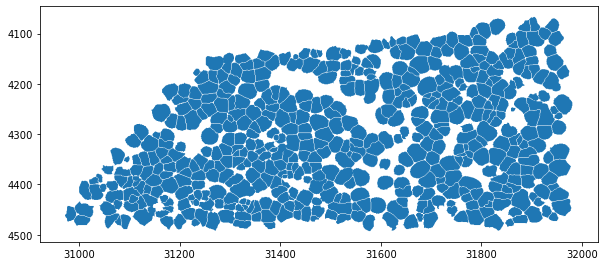

In [15]:
ax=gdf.plot(figsize=(10,10))
ax.invert_yaxis()